<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/image_classification/mlp_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import required libraries
import torch
import torchvision

import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("CUDA is available")
else:
  print("CUDA is not available")

device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is available


In [ ]:
# set up the general configeration

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

random_seed = 125
set_all_seeds(random_seed)

### Load and visualize the dataset

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load dataset from torchvision.datasets
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# obtain training indices for creating a validation dataset
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
# choose percentage of training data for validation
valid_size = 0.2
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

## define dataloader parameters

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare train, test and validation data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# image classes in the dataset
classes = ['0','1','2','3','4','5', '6','7','8','9']
num_classes = len(classes)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# print out some data stats

print("Number of training images: ", len(train_data))
print("Number of test images: ", len(test_data))

for inputs, targets in train_loader:  
    print('Image batch dimensions:', inputs.shape)
    print('Image label dimensions:', targets.shape)
    print('Class labels of 10 examples:', targets[:10])
    break

Number of training images:  60000
Number of test images:  10000
Image batch dimensions: torch.Size([20, 1, 28, 28])
Image label dimensions: torch.Size([20])
Class labels of 10 examples: tensor([5, 7, 5, 1, 4, 8, 8, 1, 9, 6])


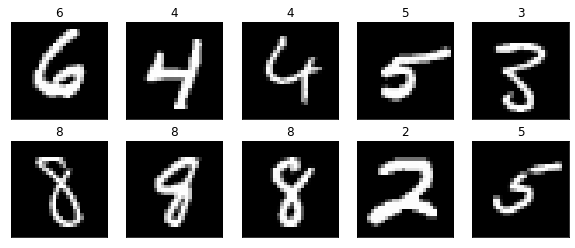

In [ ]:
## visualize a batch of training data

def imshow(img):
  plt.imshow(np.squeeze(img), cmap='gray')

# obtain one batch of training images
dataiter = iter(train_loader)
inputs, targets = dataiter.next()
inputs = inputs.numpy()

# plot some images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(inputs[idx])
    ax.set_title(str(targets[idx].item()))

### Define a neural network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28*28, 512) 
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512,512)
    self.fc4 = nn.Linear(512, 10)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = self.fc4(x)
    return x
  
model = Net()
# move model to the right device
model.to(device)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
from torchsummary import summary

# display model
summary(model, input_size=(batch_size, 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
           Dropout-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
           Dropout-6                  [-1, 512]               0
            Linear-7                   [-1, 10]           5,130
Total params: 932,362
Trainable params: 932,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.02
Params size (MB): 3.56
Estimated Total Size (MB): 3.64
----------------------------------------------------------------


### Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

# specify loss
criterion = nn.CrossEntropyLoss() # categorical cross-entropy loss

# specify optimizer
params = model.parameters()
optimizer = optim.Adam(params, lr=0.001)
# learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.01)

### Train the model on the training dataset

In [ ]:
# number of epochs to train the model
num_epochs = 20

# track training and validation losses
train_loss_list, valid_loss_list = [], []

# initialize trackers for min validation loss
min_valid_loss = np.inf

for epoch in range(num_epochs):
  running_train_loss = 0.0
  running_valid_loss = 0.0

  #--------- train the model -----------
  # set model to training mode
  model.train()

  for batch_idx, data in enumerate(train_loader):
    # get the inputs; data is a list of [inputs, targets]
    inputs, targets = data
    # move tensor to the right device
    inputs, targets = inputs.to(device), targets.to(device)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass
    outputs = model(inputs)
    # calculate the batch loss
    loss = criterion(outputs, targets)
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # update training loss
    running_train_loss += loss.item()
  
  # -------- validate the model ---------
  # set model to evaluation mode
  model.eval()

  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(valid_loader):
      # move tensor to the right device
      inputs, targets = inputs.to(device), targets.to(device)
      # forward pass
      outputs = model(inputs)
      # calculate the batch loss
      loss = criterion(outputs, targets)
      # update validation loss
      running_valid_loss += loss.item()

  # update the learning rate
  lr_scheduler.step()

  # calculate average loss over an epoch
  running_train_loss = running_train_loss / len(train_loader)
  running_valid_loss = running_valid_loss / len(valid_loader)

  train_loss_list.append(running_train_loss)
  valid_loss_list.append(running_valid_loss)

  print("Epoch: {} \tTraining loss: {:.6f} \tValidation loss: {:.6f}".format(epoch+1, running_train_loss, running_valid_loss))

  # save model if validation loss has decreased
  if running_valid_loss <= min_valid_loss:
    print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ... ".format(
        min_valid_loss, running_valid_loss
    ))

    torch.save(model.state_dict(), 'mlp_mnist_model.pt')
    min_valid_loss = running_valid_loss

print("Finished training!")

Epoch: 1 	Training loss: 0.382329 	Validation loss: 0.185279
Validation loss decreased (inf --> 0.185279). Saving model ... 
Epoch: 2 	Training loss: 0.229177 	Validation loss: 0.129241
Validation loss decreased (0.185279 --> 0.129241). Saving model ... 
Epoch: 3 	Training loss: 0.204663 	Validation loss: 0.115036
Validation loss decreased (0.129241 --> 0.115036). Saving model ... 
Epoch: 4 	Training loss: 0.184950 	Validation loss: 0.110990
Validation loss decreased (0.115036 --> 0.110990). Saving model ... 
Epoch: 5 	Training loss: 0.178435 	Validation loss: 0.109517
Validation loss decreased (0.110990 --> 0.109517). Saving model ... 
Epoch: 6 	Training loss: 0.169435 	Validation loss: 0.109617
Epoch: 7 	Training loss: 0.140473 	Validation loss: 0.097787
Validation loss decreased (0.109517 --> 0.097787). Saving model ... 
Epoch: 8 	Training loss: 0.123863 	Validation loss: 0.093302
Validation loss decreased (0.097787 --> 0.093302). Saving model ... 
Epoch: 9 	Training loss: 0.120322 

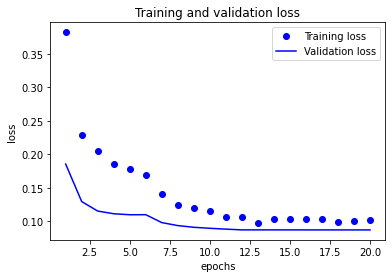

In [ ]:
# plot training and validation loss for each epoch
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_loss_list, 'bo', label='Training loss')
plt.plot(epochs, valid_loss_list, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Evaluate the performance of the trained model on the test dataset

In [ ]:
# load model with the lowest validation loss
model.load_state_dict(torch.load('mlp_mnist_model.pt'))

<All keys matched successfully>

In [ ]:
# track test loss and accuracy
test_loss = 0.0
class_correct = [0 for i in range(num_classes)]
class_total = [0 for i in range(num_classes)]

model.eval()
with torch.no_grad():
  for batch_idx, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    # update test loss
    test_loss += loss.item()
    # convert output probabilities to predicted class
    # the class with the highest energy is what we choose as prediction
    _, predictions = torch.max(outputs, 1)
    # compare predictions to true labels
    correct_tensor = predictions.eq(targets.data.view_as(predictions))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each class
    for i in range(len(targets)):
      label = targets.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader.dataset)
print(f"Test loss (overall): {test_loss}")

# print test accuracy for each classes
for i in range(len(classes)):
  if class_total[i] > 0:
    accuracy = (100 * class_correct[i]) / class_total[i]
    print(f'Test accuracy of {classes[i]:10s}: {accuracy:.1f} % ({np.sum(class_correct[i])}/{np.sum(class_total[i])})')

# overall test accuracy
test_acc = 100 * np.sum(class_correct) / np.sum(class_total)
print("\nTest accuracy (overall): %2d%% (%2d/%2d)" % ( 
      test_acc, np.sum(class_correct), np.sum(class_total)))

Test loss (overall): 0.004262642789288864
Test accuracy of 0         : 99.0 % (970/980)
Test accuracy of 1         : 98.9 % (1122/1135)
Test accuracy of 2         : 97.8 % (1009/1032)
Test accuracy of 3         : 97.3 % (983/1010)
Test accuracy of 4         : 97.9 % (961/982)
Test accuracy of 5         : 98.0 % (874/892)
Test accuracy of 6         : 98.1 % (940/958)
Test accuracy of 7         : 97.8 % (1005/1028)
Test accuracy of 8         : 96.7 % (942/974)
Test accuracy of 9         : 96.5 % (974/1009)

Test accuracy (overall): 97% (9780/10000)


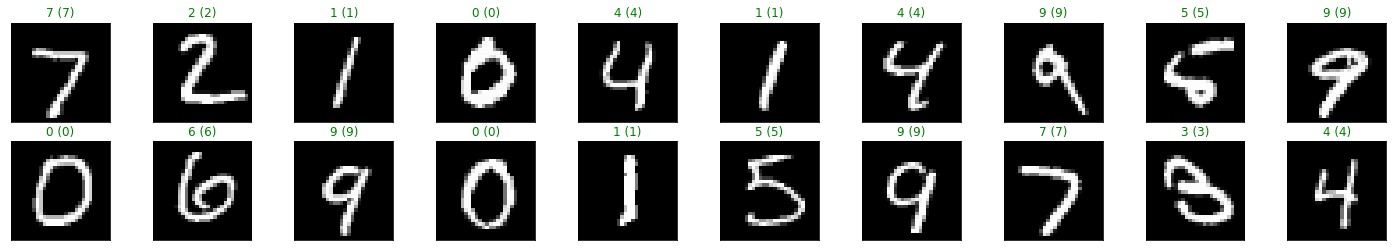

In [ ]:
## visualize a sample test results

# obtain one batch of test images
dataiter = iter(test_loader)
inputs, targets = dataiter.next()
inputs.numpy()
inputs = inputs.to(device)

# get sample outputs
outputs = model(inputs)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(outputs, 1)
predictions = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(inputs[idx] if not train_on_gpu else inputs[idx].cpu())
    ax.set_title("{} ({})".format(classes[predictions[idx]], classes[targets[idx]]),
                 color=("green" if predictions[idx]==targets[idx].item() else "red"))